In [57]:
%matplotlib inline
import isce
import os
import glob
import numpy as np
import shutil
from osgeo import gdal
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
from uavsar_pytools.georeference import geolocate_uavsar
from pathlib import Path
from glob import glob
from uavsar_pytools.convert.tiff_conversion import read_annotation, array_to_tiff
from os.path import join, basename, dirname
from rasterio.vrt import WarpedVRT
from osgeo import gdal, osr
import logging
# Set the logging level to suppress debug messages
logging.getLogger('rasterio').setLevel(logging.WARNING)

In [58]:
### still need to hand format unw vrt files....

In [63]:
# combine lkv files
def combo_lkvs(data_dir: Path, ann_fp: Path):
    """
    Combines segment .lkv files into a single combined .lkv file and saves as a binary with .vrt.
    """
    assert data_dir.exists()

    re_lkvs = {'east':[], 'north': [], 'up':[]}
    for lkvs in sorted(data_dir.glob('*.lkv')):
        segment = lkvs.stem.split('_')[-2].replace('s','')

        data = np.fromfile(lkvs, np.dtype('<f'))
        east, north, up = data[::3], data[1::3], data[2::3]
        for key, da in zip(re_lkvs.keys(), [east, north, up]):
            re_lkvs[key].extend(da)
                               
    full = np.empty(len(re_lkvs['east'])*3, dtype='>f')
    full[0::3] = re_lkvs['east']
    full[1::3] = re_lkvs['north']
    full[2::3] = re_lkvs['up']

    # read ann file
    desc = read_annotation(ann_fp)
    print('reading .ann file')

    # read in number of rows from each lvk file
    nrows1 = desc[f'lkv_1_2x8.set_rows']['value']
    nrows2 = desc[f'lkv_2_2x8.set_rows']['value']

    # add rows for new reshaping number
    nrows_new = nrows1 + nrows2
    print('new number of rows = ',nrows_new)
    
    # read in cols, same fo rboth
    ncols = desc[f'lkv_1_2x8.set_cols']['value']
    dt = np.dtype('<f')

    # create empty arrays for lat and lon
    east_array = np.empty((nrows_new, ncols))
    north_array = np.empty((nrows_new, ncols))
    up_array = np.empty((nrows_new, ncols))
    
    
    # fill each layer
    east_array = full[::3].reshape(nrows_new, ncols)
    north_array = full[1::3].reshape(nrows_new, ncols)
    up_array = full[2::3].reshape(nrows_new, ncols)

    # define path to bin file
    east_output_file = data_dir / "multi_seg.east"
    north_output_file = data_dir / "multi_seg.north"
    up_output_file = data_dir / "multi_seg.up"


    #### Save the array to bin file
    # east
    east_array.tofile(east_output_file)
    print('.east saved')
    
    # north
    north_array.tofile(north_output_file)
    print('.north saved')

    # up
    up_array.tofile(up_output_file)
    print('.up saved')

    profile = {
    'driver': 'GTiff',
    'interleave': 'band',
    'tiled': False,
    'nodata': 0,
    'width': ncols,
    'height':nrows_new,
    'count':1,
    'dtype':'float32'
    }
    
    ### Save out tifs to be converted to vrt
    # east
    with rio.open(join(str(east_output_file) + '.tif'), 'w', **profile) as dst:
                dst.write(east_array.astype(east_array.dtype), 1)
        
    # north
    with rio.open(join(str(north_output_file) + '.tif'), 'w', **profile) as dst:
                dst.write(north_array.astype(north_array.dtype), 1)
    # north
    with rio.open(join(str(up_output_file) + '.tif'), 'w', **profile) as dst:
                dst.write(up_array.astype(up_array.dtype), 1)

    # Add VRT file for each tif
    tifs = glob(join(data_dir, '*.tif')) # list all .lvk files
    for tiff in tifs: # loop to open and translate .lvk to .vrt, and save .vrt using gdal
        raster_dataset = gdal.Open(tiff, gdal.GA_ReadOnly) # read in rasters
        raster = gdal.Translate(join(data_dir, basename(tiff).replace('.tif','.vrt')), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)
    raster_dataset = None

    print('new .east, .north, and .up with .vrt have saved')

In [64]:
# start in downloads directory
os.chdir('/Users/jtarrico/ch3_fusion/rasters/')

In [65]:
dir1 = Path('./cop_dem_30m/')
ann1 = Path('./cop_dem_30m/sierra_35402_20002_000_200131_L090HH_01_BC.ann')

In [62]:
full1 = combo_lkvs(data_dir = dir1, ann_fp = ann1)

reading .ann file
new number of rows =  16215
.east saved
.north saved
.up saved


/Users/jtarrico/miniconda/envs/isce2_env/lib/python3.9/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


new .east, .north, and .up with .vrt have saved


In [66]:
def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    From: Dr. Gareth Funning, UC Riverside, UNAVCO InSAR Short Course
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = 'temp_ele.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()
    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 
                        'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    print('geocoding...')
    if spacing is None:
        spacing = [None, None]
    warpOptions = gdal.WarpOptions(format=fmt,
                                xRes=spacing[0], yRes=spacing[0],
                                dstSRS=outsrs, outputBounds = bounds, dstNodata = -9999,
                                resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)
    os.remove('temp_ele.vrt')
    print('done!')

In [67]:
# east geolocate
in_fp = './cop_dem_30m/multi_seg.east.vrt'

# path to annotation file
lat_fp = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lat.vrt'

# path to annotation file
lon_fp = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lon.vrt'

# where the .tif is being save
out_fp = './cop_dem_30m/multi_seg.east.gc.tif'

In [68]:
# p1 unw
geocodeUsingGdalWarp(infile = in_fp,
                     latfile = lat_fp, 
                     lonfile = lon_fp, 
                     outfile = out_fp,
                     insrs=4326, outsrs=None,spacing=[.00005556,.00005556], fmt='GTiff', bounds=None,method='near')

geocoding...
done!


In [69]:
# north geolocate
in_fp2 = './cop_dem_30m/multi_seg.north.vrt'

# path to annotation file
lat_fp2 = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lat.vrt'

# path to annotation file
lon_fp2 = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lon.vrt'

# where the .tif is being save
out_fp2 = './cop_dem_30m/multi_seg.north.gc.tif'

In [70]:
geocodeUsingGdalWarp(infile = in_fp2,
                     latfile = lat_fp2, 
                     lonfile = lon_fp2, 
                     outfile = out_fp2,
                     insrs=4326, outsrs=None,spacing=[.00005556,.00005556], fmt='GTiff', bounds=None,method='near')

geocoding...
done!


In [71]:
# north geolocate
in_fp3 = './cop_dem_30m/multi_seg.up.vrt'

# path to annotation file
lat_fp3 = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lat.vrt'

# path to annotation file
lon_fp3 = '/Users/jtarrico/sierra_isce_multi/int/new_llh/multi_seg.lon.vrt'

# where the .tif is being save
out_fp3 = './cop_dem_30m/multi_seg.up.gc.tif'

In [72]:
geocodeUsingGdalWarp(infile = in_fp3,
                     latfile = lat_fp3, 
                     lonfile = lon_fp3, 
                     outfile = out_fp3,
                     insrs=4326, outsrs=None,spacing=[.00005556,.00005556], fmt='GTiff', bounds=None,method='near')

geocoding...
done!


In [73]:
# define inc fun
def arccos_theta(v):
    if v < 1 and v > -1:
        return np.arccos(v)
    elif v > 1 and v < 3:
        return np.arccos(2-v)
    elif v < -1 and v > -3:
        return np.arccos(-1 + 0.000001) - np.arccos(2+v)
    else:
        return np.nan

arccos_theta = np.vectorize(arccos_theta)


def calc_inc_angle(dem, lkv_x, lkv_y, lkv_z, pixel_size=5.556):
    """
    Calculates UAVSAR incidence angle from DEM and look vector components.

    Parameters
    ----------
    dem, lkv_x, lkv_y, lkv_z : np.array or str
        Elevation data and the three components of the look vector.
        Strings are treated as filepaths to be handled by rasterio.
    pixel_size : float
        Pixel size of all components in [m]. Default value is for 
        UAVSAR images from JPL.
    
    Returns
    -------
    inc : np.array
        Incidence angle in degrees.
    """
    # Calculate gradient of DEM
    if type(dem) == str:
        with rio.open(dem) as src:
            dem_arr = src.read(1)
            dx, dy = np.gradient(dem_arr, pixel_size)
            dem_shape = dem_arr.shape
    elif type(dem) == np.ndarray:
        dx, dy = np.gradient(dem, pixel_size)
        dem_shape = dem.shape
    else:
        raise ValueError('Pass filepath or np.array for DEM data.')

    # Look vectors
    lkv = {}
    components = [lkv_x, lkv_y, lkv_z]
    directions = ['x','y','z']

    for comp_idx, vector in enumerate(components):
        if type(vector) == str:
            with rio.open(vector) as src:
                lkv[directions[comp_idx]] = src.read(1)
        elif type(vector) == np.ndarray:
            assert vector.shape == dem_shape, 'Look vector data must be the same shape as DEM data.'
            lkv[directions[comp_idx]] = vector
        else:
            raise ValueError('Pass filepath or np.array for DEM data.')
        
    # Calculate look vector magnitude
    lkv_mag = np.zeros_like(lkv['x'])
    for direction, arr in lkv.items():
        lkv_mag = lkv_mag + arr**2
    lkv_mag = lkv_mag**0.5
    lkv_mag[lkv_mag == 0] = np.nan
    # Unit vectors
    unit_lkv = {}
    for direction, arr in lkv.items():
        unit_lkv[direction] = -arr/lkv_mag

    # Calculate incidence angle
    inc_cos = unit_lkv['x']*dx + unit_lkv['y']*dy + unit_lkv['z']
    inc = arccos_theta(inc_cos)

    return inc

In [75]:
inc = calc_inc_angle(dem = './cop_dem_30m/cop_resamp.tif',
lkv_x = './cop_dem_30m/multi_seg.east.gc.tif',
lkv_y = './cop_dem_30m/multi_seg.north.gc.tif',
lkv_z = './cop_dem_30m/multi_seg.up.gc.tif')

In [76]:
inc

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

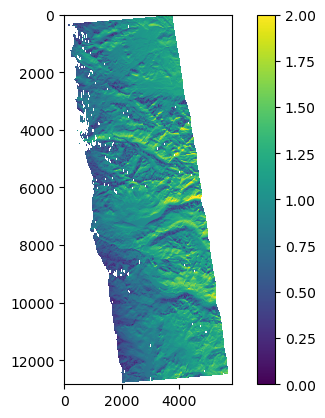

In [77]:
plt.imshow(inc, vmin=0, vmax=2)
plt.colorbar()

In [78]:
# Define metadata for the raster
metadata = {
    'driver': 'GTiff',  # GeoTIFF format
    'count': 1,          # number of bands
    'dtype': 'float64',  # data type of the array
    'width': inc.shape[1],
    'height': inc.shape[0],
    'crs': 'EPSG:4326',  # Coordinate Reference System
    'transform': rio.transform.from_origin(0, 0, 1, 1)  # Affine transformation
}

# Specify the filename to save the raster
filename = './cop_dem_30m/new_inc_6m.tif'

# Write the raster data to a GeoTIFF file
with rio.open(filename, 'w', **metadata) as dst:
    dst.write(inc, 1)  # Write data to the first band

/Users/jtarrico/miniconda/envs/isce2_env/lib/python3.9/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
